# Crowd Count Using MCNN

An implementation of CVPR2016 paper [Single-Image Crowd Counting via Multi-Column Convolutional Neural Network](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhang_Single-Image_Crowd_Counting_CVPR_2016_paper.pdf)

This code use the pre-trained weight from this [github](https://github.com/uestcchicken/crowd-counting-MCNN)

We use Keras as an implementation **ONLY**

## Import required library

In [1]:
import keras
import numpy as np
import os 
import cv2
import matplotlib.pyplot as plt
import math
from keras import models
from keras.preprocessing.image import ImageDataGenerator
import scipy.io

Using TensorFlow backend.


## Define Necessary Function

`test_preprocessing` function recieves **PATH of images** and **dataset name** and returns preprocessed data.
The preprocessing methods include:
- Loading images in B/W , `cv.imread(img,0)`
- Normalize Image, `(img-127.5)/128`

`train_preprocessing` function receives **PATH of training images** and **PATH of density images**. It returns truple of loaded train image and density.

`get_cost_diff_epochs` function receives **min and max epochs** for displaying the different MSE of each epoch.

In [2]:
def test_preprocessing(img_path, dataset):
    print('loading data from dataset', dataset, '...')
    img_names = os.listdir(img_path)
    img_num = len(img_names)
    img_names.sort()

    data = []
    i = 1
    for name in img_names:
        if i % 50 == 0:
            print(i, '/', img_num)
        img = cv2.imread(img_path + name, 0)
        img = (img - 127.5) / 128
        data.append(img)
        i += 1
    
    print('load data finished.')
    return data

def train_preprocessing(img_path, den_path):
        print('loading training data...')
        img_names = os.listdir(img_path)
        img_num = len(img_names)
        img_names.sort()
        
        data = []
        density = []
        count = 1
        for name in img_names:
            if count % 100 == 0:
                print(count, '/', img_num)
            count += 1
            img = cv2.imread(img_path + name, 0)
            img = np.array(img)
            img = (img - 127.5) / 128
            den = np.loadtxt(open(den_path + name[:-4] + '.csv'), delimiter = ",")
            den_quarter = np.zeros((int(den.shape[0] / 4), int(den.shape[1] / 4)))
            for i in range(len(den_quarter)):
                for j in range(len(den_quarter[0])):
                    for p in range(4):
                        for q in range(4):
                            den_quarter[i][j] += den[i * 4 + p][j * 4 + q]
            data.append(np.reshape(img, [img.shape[0], img.shape[1], 1]))
            density.append(np.reshape(den_quarter, [den_quarter.shape[0], den_quarter.shape[1], 1]))
        data = np.array(data)
        density = np.array(density)
        print('load training data finished')
        return (data, density)
    
def get_ground_truth(dataset):
    gt_path = 'icanteen_img/'+dataset+'/ground_truth/'
    gt_names = os.listdir(gt_path)
    gt_names.sort()
    gt = []
    i = 1
    for file in gt_names:
        mat = scipy.io.loadmat(gt_path+file)
        gt.append(mat['image_info'][0][0][0][0][1][0][0])
        i += 1
    return gt

## Creating MCNN model with Keras
The structure of MCNN network for crowd counting is as follow:
![network](MCNN.png)
`Conv2D(out_channel, kernel_size, padding, activation)` <br>
- Apply a 2D convolution layer with an output channel of `out-channel`, kernel size of `kernel_size`, and activation function `activation`.

`MaxPooling2D(pool_size, stride)`
- Apply a 2D max pooling layer with a pool size of `pool_size`. If the `stride` argument is left blank, the value will equal to `pool_size`.

`concatnate([out1, out2, ...])`
- Concat many layers(`out1, out2, ...`) together. Note that all outputs must be equal in size.

In [3]:
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam

def get_MCNN():    
    input1 = Input(shape=(None, None, 1)) 
    
    # S
    xs = Conv2D(24, kernel_size = (5,5), padding = 'same', activation = 'relu')(input1)   
    xs = MaxPooling2D(pool_size = (2,2))(xs)
    xs = Conv2D(48, kernel_size = (3,3), padding = 'same', activation = 'relu')(xs)
    xs = MaxPooling2D(pool_size = (2,2))(xs)
    xs = Conv2D(24, kernel_size = (3,3), padding = 'same', activation = 'relu')(xs)
    xs = Conv2D(12, kernel_size = (3,3), padding = 'same', activation = 'relu')(xs)
    
    # M
    xm = Conv2D(20, kernel_size = (7,7), padding = 'same', activation = 'relu')(input1)   
    xm = MaxPooling2D(pool_size = (2,2))(xm)
    xm = Conv2D(40, kernel_size = (5,5), padding = 'same', activation = 'relu')(xm)
    xm = MaxPooling2D(pool_size = (2,2))(xm)
    xm = Conv2D(20, kernel_size = (5,5), padding = 'same', activation = 'relu')(xm)
    xm = Conv2D(10, kernel_size = (5,5), padding = 'same', activation = 'relu')(xm)
    
    # L
    xl = Conv2D(16, kernel_size = (9,9), padding = 'same', activation = 'relu')(input1)   
    xl = MaxPooling2D(pool_size = (2,2))(xl)
    xl = Conv2D(32, kernel_size = (7,7), padding = 'same', activation = 'relu')(xl)
    xl = MaxPooling2D(pool_size = (2,2))(xl)
    xl = Conv2D(16, kernel_size = (7,7), padding = 'same', activation = 'relu')(xl)
    xl = Conv2D(8, kernel_size = (7,7), padding = 'same', activation = 'relu')(xl)
    
    x = concatenate([xm, xs, xl])
    out = Conv2D(1, kernel_size = (1,1), padding = 'same')(x)
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.001),
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

    return model

In [4]:
train_path = 'image_preprocessor/data/formatted_trainval/icanteen_patches/train/'
train_path_den = 'image_preprocessor/data/formatted_trainval/icanteen_patches/train_den/'
val_path = 'image_preprocessor/data/formatted_trainval/icanteen_patches/val/'
val_path_den = 'image_preprocessor/data/formatted_trainval/icanteen_patches/val_den/'

train, train_den = train_preprocessing(train_path, train_path_den)
val, val_den = train_preprocessing(val_path, val_path_den)

loading training data...
100 / 252
200 / 252
load training data finished
loading training data...
load training data finished


## Get and load a model
Initialize the model with `get_MCNN()` and load pre-trained weights. 

`model.summary()` is used to get the model summary.

In [5]:
model = get_MCNN()
model.load_weights('keras_weight/weights.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 2 1000        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 2 624         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, None, 1 1312        input_1[0][0]                    
__________________________________________________________________________________________________
max_poolin

## Predict results from the loaded weight

In [6]:
test_path = 'icanteen_img/test/images/'
data = test_preprocessing(test_path, 'icanteen')

loading data from dataset icanteen ...
load data finished.


==========IMG_31.jpg==========
ERROR: 26.0
==========IMG_32.jpg==========
ERROR: 32.0
==========IMG_33.jpg==========
ERROR: 62.0
==========IMG_34.jpg==========
ERROR: 35.0
==========IMG_35.jpg==========
ERROR: 39.0
==========IMG_36.jpg==========
ERROR: 33.0
==========IMG_37.jpg==========
ERROR: 35.0
==========IMG_38.jpg==========
ERROR: 50.0
==========IMG_39.jpg==========
ERROR: 39.0
==========IMG_40.jpg==========
ERROR: 51.0
Mean Absolute Error: 40.2
Mean Square Error: 41.50421665325103


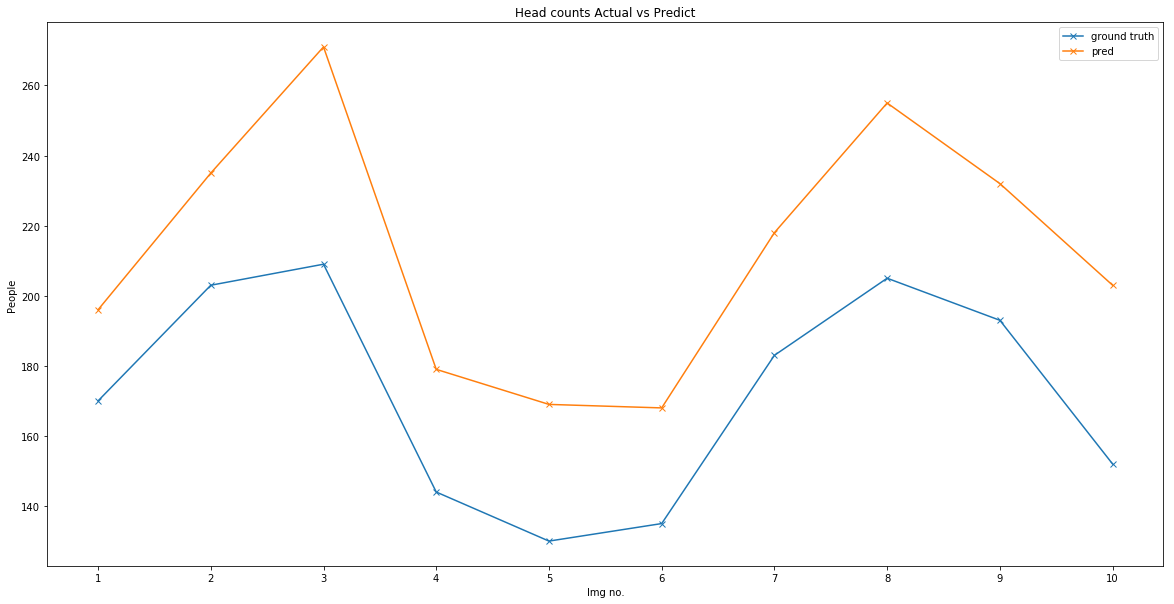

In [7]:
mae = 0
mse = 0
ground_truth = get_ground_truth('test')
pred = []

i = 0
for d in data:
    inputs = np.reshape(d, [1, d.shape[0], d.shape[1], 1])
    outputs = model.predict(inputs)
    c_pre = round(np.sum(outputs))
    pred.append(c_pre)
    print('='*10+'IMG_'+str(i+31)+'.jpg'+'='*10)
    mae += abs(ground_truth[i]-c_pre)
    mse += (ground_truth[i]-c_pre)**2
    print('ERROR:',abs(ground_truth[i]-c_pre))
    i += 1
    
print('Mean Absolute Error:',mae/len(ground_truth))
print('Mean Square Error:',math.sqrt(mse/len(ground_truth)))

plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, len(data)+1),ground_truth, marker='x')
plt.plot(np.arange(1,len(data)+1),pred, marker='x')
plt.xticks(np.arange(1,len(data)+1))
plt.xlabel('Img no.')
plt.ylabel('People')
plt.legend(['ground truth', 'pred'])
plt.title('Head counts Actual vs Predict')
plt.show()

## Select optimum epoch that yield the least MAE

In [8]:
def get_cost_diff_epochs(min_epoch, max_epoch):
    
    val_path = 'icanteen_img/val_epoch/images/'
    data = test_preprocessing(val_path, 'icanteen')
    
    mean_absolute_error = []
    mean_square_error = []
    for i in range(min_epoch, max_epoch+1):
        print('='*20,'TRAINING EPOCH =',i,'='*20)
        # Load network
        model = get_MCNN()
        model.load_weights('keras_weight/weights.h5')

        # Fine-tune only last 2 layers
        for layer in model.layers[:-2]:
            layer.trainable = False

        # Load fine-tune model
        mcnn = models.Sequential()
        mcnn.add(model)

        # set epochs and batch_size
        epochs = i
        batch_size = 1

        # load train, val
        aug = ImageDataGenerator()
        train_generator = aug.flow(train, train_den, batch_size = batch_size, shuffle = True)
        val_generator = aug.flow(val, val_den, batch_size = batch_size, shuffle = True)  

        # compile and train model
        mcnn.compile(loss='mae',
                  optimizer=Adam(0.0001),
                  metrics=['mae'])

        print('start training MCNN...')
        print("train with {} epochs and {} batch size".format(epochs, batch_size))
        history = mcnn.fit_generator(train_generator,
                                    steps_per_epoch = math.ceil(train.shape[0]/train_generator.batch_size),
                                    epochs = epochs,
                                    validation_data = val_generator,
                                    validation_steps = math.ceil(val.shape[0]/val_generator.batch_size),
                                    verbose = 1)


        mae = 0
        mse = 0
        ground_truth = get_ground_truth('val_epoch')
        pred = []

        i = 0
        for d in data:
            if i>len(ground_truth)-1:
                continue
            inputs = np.reshape(d, [1, d.shape[0], d.shape[1], 1])
            outputs = model.predict(inputs)
            c_pre = round(np.sum(outputs))
            pred.append(c_pre)
            mae += abs(ground_truth[i]-c_pre)
            mse += (ground_truth[i]-c_pre)**2
            i += 1

        mean_absolute_error.append(mae/len(ground_truth))
        mean_square_error.append(math.sqrt(mse/len(ground_truth)))
    
    return (mean_absolute_error, mean_square_error)

In [9]:
min_epochs = 1
max_epochs = 10
mean_abs_err, mean_sqr_err = get_cost_diff_epochs(min_epochs,max_epochs)

loading data from dataset icanteen ...
load data finished.
==================== TRAINING EPOCH = 1 ====================
start training MCNN...
train with 1 epochs and 1 batch size
Epoch 1/1
252/252 [==============================] - 4s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 0.0017 - val_mean_absolute_error: 0.0017
==================== TRAINING EPOCH = 2 ====================
start training MCNN...
train with 2 epochs and 1 batch size
Epoch 1/2
252/252 [==============================] - 3s 13ms/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 0.0017 - val_mean_absolute_error: 0.0017
Epoch 2/2
252/252 [==============================] - 3s 11ms/step - loss: 0.0016 - mean_absolute_error: 0.0016 - val_loss: 0.0016 - val_mean_absolute_error: 0.0016
==================== TRAINING EPOCH = 3 ====================
start training MCNN...
train with 3 epochs and 1 batch size
Epoch 1/3
252/252 [==============================] - 3s 13ms/step - loss: 0.0018 - mea

Epoch 8/9
252/252 [==============================] - 3s 12ms/step - loss: 0.0014 - mean_absolute_error: 0.0014 - val_loss: 0.0014 - val_mean_absolute_error: 0.0014
Epoch 9/9
252/252 [==============================] - 3s 12ms/step - loss: 0.0014 - mean_absolute_error: 0.0014 - val_loss: 0.0014 - val_mean_absolute_error: 0.0014
==================== TRAINING EPOCH = 10 ====================
start training MCNN...
train with 10 epochs and 1 batch size
Epoch 1/10
252/252 [==============================] - 4s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 0.0017 - val_mean_absolute_error: 0.0017
Epoch 2/10
252/252 [==============================] - 3s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0016 - val_loss: 0.0017 - val_mean_absolute_error: 0.0017
Epoch 3/10
252/252 [==============================] - 3s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0016 - val_loss: 0.0016 - val_mean_absolute_error: 0.0016
Epoch 4/10
252/252 [==============================] - 

Minumum MAE at epoch 2 with MAE = 14.4
Minumum MSE at epoch 1 with MSE = 19.308029417835474


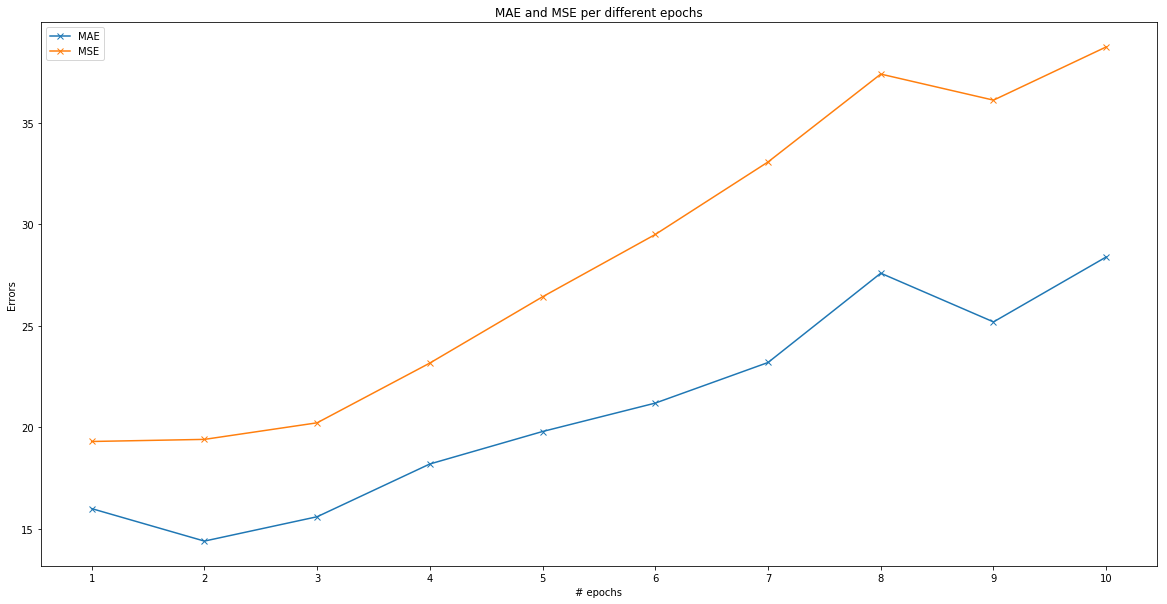

In [10]:
min_mae_epochs = np.argmin(mean_abs_err)
min_mse_epochs = np.argmin(mean_sqr_err)

print('Minumum MAE at epoch',min_mae_epochs+1,'with MAE =',mean_abs_err[min_mae_epochs])
print('Minumum MSE at epoch',min_mse_epochs+1,'with MSE =',mean_sqr_err[min_mse_epochs])

plt.figure(figsize=(20, 10))
plt.plot(np.arange(min_epochs, max_epochs+1),mean_abs_err, marker='x')
plt.plot(np.arange(min_epochs, max_epochs+1),mean_sqr_err, marker='x')
plt.xticks(np.arange(min_epochs, max_epochs+1))
plt.xlabel('# epochs')
plt.ylabel('Errors')
plt.legend(['MAE', 'MSE'])
plt.title('MAE and MSE per different epochs')
plt.show()

In [11]:
for layer in model.layers[:-2]:
    layer.trainable = False
    
for layer in model.layers:
    print(layer, layer.trainable)
    
mcnn = models.Sequential()
mcnn.add(model)

mcnn.summary()

<keras.engine.input_layer.InputLayer object at 0x7f9b1fb40e80> False
<keras.layers.convolutional.Conv2D object at 0x7f9b1f985518> False
<keras.layers.convolutional.Conv2D object at 0x7f9b1fb40b38> False
<keras.layers.convolutional.Conv2D object at 0x7f9b0c3513c8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b1fa1a518> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b1fb406a0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b0c364208> False
<keras.layers.convolutional.Conv2D object at 0x7f9b1fa1aeb8> False
<keras.layers.convolutional.Conv2D object at 0x7f9b1fb400f0> False
<keras.layers.convolutional.Conv2D object at 0x7f9b0c364b70> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b1fa45080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b1f95f128> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9b1f9a6240> False
<keras.layers.convolutional.Conv2D object at 0x7f9b1fa457f0> False
<keras.layers.convolutional.Conv2D object at 0x7f9b1f95f588>

In [12]:
epochs = min_mae_epochs+1
batch_size = 1
aug = ImageDataGenerator()

train_generator = aug.flow(train, train_den, batch_size = batch_size, shuffle = True)
val_generator = aug.flow(val, val_den, batch_size = batch_size, shuffle = True)

In [13]:
mcnn.compile(loss='mae',
              optimizer=Adam(0.0001),
              metrics=['mae'])

print('start training MCNN...')
print("train with {} epochs and {} batch size".format(epochs, batch_size))
history = mcnn.fit_generator(train_generator,
                            steps_per_epoch = math.ceil(train.shape[0]/train_generator.batch_size),
                            epochs = epochs,
                            validation_data = val_generator,
                            validation_steps = math.ceil(val.shape[0]/val_generator.batch_size),
                            verbose = 1)

mcnn.save('keras_weight/trained.h5')

start training MCNN...
train with 2 epochs and 1 batch size
Epoch 1/2
252/252 [==============================] - 4s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0018 - val_loss: 0.0017 - val_mean_absolute_error: 0.0017
Epoch 2/2
252/252 [==============================] - 3s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0016 - val_loss: 0.0017 - val_mean_absolute_error: 0.0017


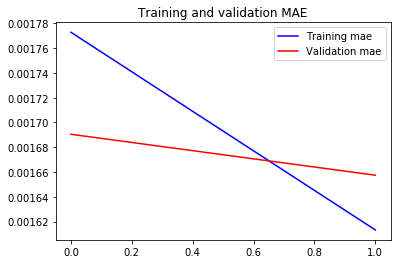

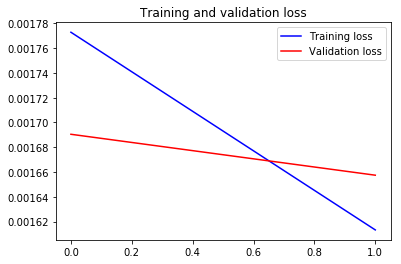

In [14]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(mae))
 
plt.plot(epochs, mae, 'b', label='Training mae')
plt.plot(epochs, val_mae, 'r', label='Validation mae')
plt.title('Training and validation MAE')
plt.legend()
 
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Predict each image!
Iterate over the preprocessed data (`data`) and predict total number of people of each image.

In [15]:
test_path = 'icanteen_img/test/images/'
data = test_preprocessing(test_path, 'icanteen')

loading data from dataset icanteen ...
load data finished.


==========IMG_35.jpg==========
IMG_35 predicted  140.0 people
IMG_35 actual 170 people
ERROR: 30.0
current MAE: 30.0
current MSE: 30.0
==========IMG_36.jpg==========
IMG_36 predicted  181.0 people
IMG_36 actual 203 people
ERROR: 22.0
current MAE: 26.0
current MSE: 26.3058928759
==========IMG_37.jpg==========
IMG_37 predicted  209.0 people
IMG_37 actual 209 people
ERROR: 0.0
current MAE: 17.3333333333
current MSE: 21.4786715914
==========IMG_38.jpg==========
IMG_38 predicted  132.0 people
IMG_38 actual 144 people
ERROR: 12.0
current MAE: 16.0
current MSE: 19.5448202857
==========IMG_39.jpg==========
IMG_39 predicted  118.0 people
IMG_39 actual 130 people
ERROR: 12.0
current MAE: 15.2
current MSE: 18.2866071211
==========IMG_40.jpg==========
IMG_40 predicted  117.0 people
IMG_40 actual 135 people
ERROR: 18.0
current MAE: 15.6666666667
current MSE: 18.2391520271
==========IMG_41.jpg==========
IMG_41 predicted  159.0 people
IMG_41 actual 183 people
ERROR: 24.0
current MAE: 16.8571428571
cu

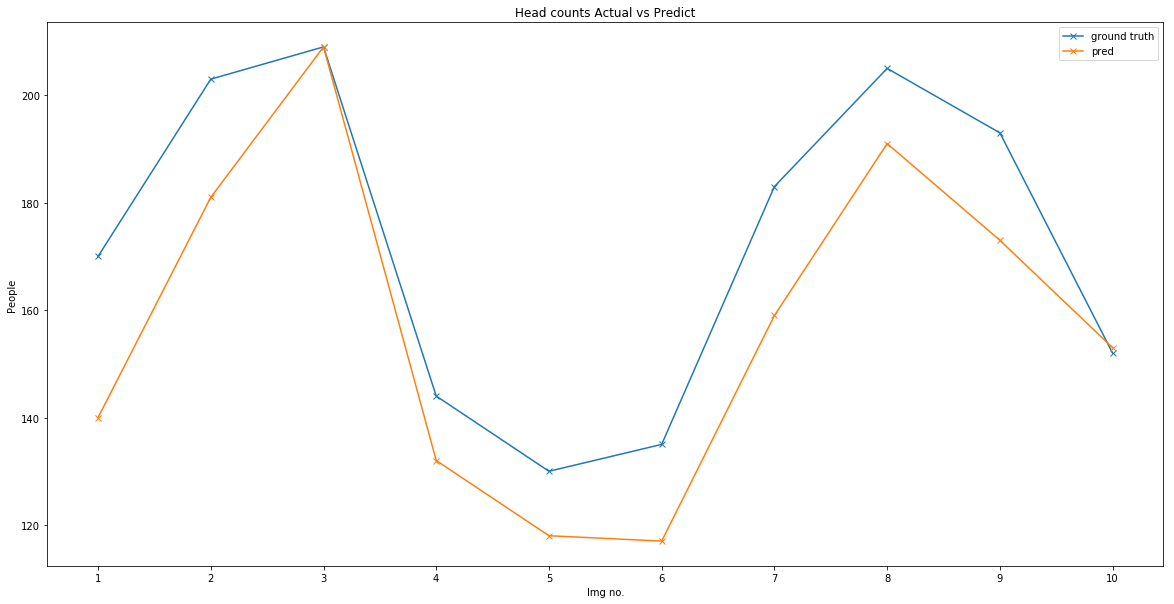

In [16]:
mae = 0
mse = 0
ground_truth = get_ground_truth('test')
pred = []

initial_num = 35
i = 0
for d in data:
    inputs = np.reshape(d, [1, d.shape[0], d.shape[1], 1])
    outputs = model.predict(inputs)
    c_pre = round(np.sum(outputs))
    pred.append(c_pre)
    print('='*10+'IMG_'+str(i+initial_num)+'.jpg'+'='*10)
    print('IMG_'+str(i+initial_num),'predicted ', c_pre,'people')
    print('IMG_'+str(i+initial_num),'actual',ground_truth[i], 'people')
    mae += abs(ground_truth[i]-c_pre)
    mse += (ground_truth[i]-c_pre)**2
    print('ERROR:',abs(ground_truth[i]-c_pre))
    print('current MAE:',mae/(i+1))
    print('current MSE:',(mse/(i+1))**0.5)
    
#     plt.figure(figsize=(15, 7.5))
#     plt.imshow(inputs.reshape(inputs.shape[1], inputs.shape[2]), cmap='gray')
#     plt.title('test_'+str(i+1))
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
#     plt.figure(figsize=(15, 7.5))
    
    den = outputs.reshape(outputs.shape[1], outputs.shape[2])
#     plt.imshow(den)
#     plt.title('heatmap_IMG_'+str(i+1))
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
    
    den_name = 'heat_'+'IMG_'+str(i+initial_num)+'.png'
    plt.imsave('icanteen_heat/'+den_name, den)
    i += 1
    
print('Mean Absolute Error:',mae/len(ground_truth))
print('Mean Square Error:',math.sqrt(mse/len(ground_truth)))

plt.figure(figsize=(20, 10))
plt.plot(np.arange(1,len(ground_truth)+1),ground_truth, marker='x')
plt.plot(np.arange(1,len(ground_truth)+1),pred, marker='x')
plt.xticks(np.arange(1,len(ground_truth)+1))
plt.xlabel('Img no.')
plt.ylabel('People')
plt.legend(['ground truth', 'pred'])
plt.title('Head counts Actual vs Predict')
plt.show()

## HTTP Post on a server
In this cell, we are trying to do a **HTTP POST** command to send a JSON object (containing head counted and current timestamp) to the server.

In [17]:
import requests
import datetime

def http_POST_current_time(head_count):
    db_path = 'https://enqzgrfms9dop.x.pipedream.net/'
    currentDT = datetime.datetime.now()
    YYMMDD = str(currentDT.year)+'-'+str(currentDT.month)+'-'+str(currentDT.day)
    TIME = str(currentDT.hour)+':'+str(currentDT.minute)+':'+str(currentDT.second)
    date = YYMMDD + ' ' + TIME
    data = {
        'time_stamp': date,
        'crowd_size': head_count
    }

    r = requests.post(db_path, data=data)
    
http_POST_current_time(5)